<a href="https://colab.research.google.com/github/schaeffer-thom/ML-projects/blob/main/IK_6dof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("luisatencio/abb-irb-2400-arm-robot-kinematics-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/abb-irb-2400-arm-robot-kinematics-dataset


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [27]:
data = pd.read_csv('/kaggle/input/abb-irb-2400-arm-robot-kinematics-dataset/datasetIRB2400.csv')
data = data.rename(columns={f"q{i}_out": f"q{i}" for i in range(1, 7)})

y = data[['q1','q2','q3','q4','q5','q6']]

x = data[['x','y','z','roll','pitch','yaw']]


x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

#print(data.info())
#data.head()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


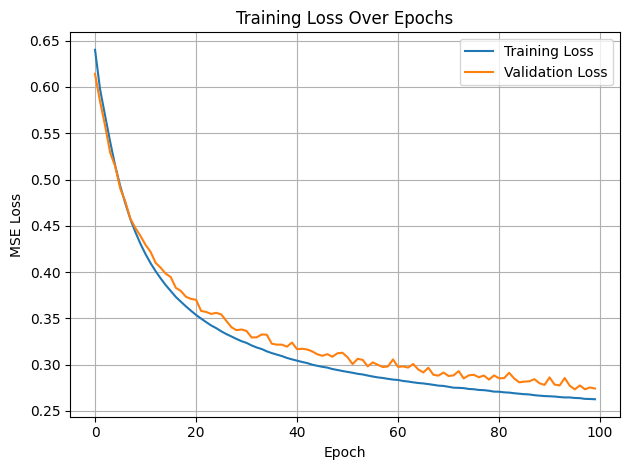

In [30]:
# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(x_train)
X_test = scaler_X.transform(x_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Build the model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(6,)),  # XYZ+RPY
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(6)  # 6 joint angles output
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
model.save("ik_model.h5")  # Saves architecture, weights, and optimizer state


NameError: name 'model' is not defined

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Convert degrees to radians
def deg2rad(deg):
    return deg * np.pi / 180

# Compute individual DH transformation matrix
def dh_transform(a, alpha, d, theta):
    alpha, theta = deg2rad(alpha), deg2rad(theta)
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

# Forward kinematics function
def forward_kinematics(joint_angles):
    """
    joint_angles: list or array of 6 joint angles in degrees
    returns: 4x4 transformation matrix of the end-effector
    """
    assert len(joint_angles) == 6

    # DH Parameters: (a, alpha, d, theta)
    dh_params = [
        (0,    0,    0,   joint_angles[0]),
        (97,  -90,  440,  joint_angles[1]),
        (705,   0,    0,  joint_angles[2]),
        (135, -90,  264,  joint_angles[3]),
        (0,    90,  497,  joint_angles[4]),
        (0,   -90,   65,  joint_angles[5])
    ]

    T = np.eye(4)
    for a, alpha, d, theta in dh_params:
        T = np.dot(T, dh_transform(a, alpha, d, theta))

    return T

# Example usage
angles = [0, 0, 0, 0, 0, 0]  # All joints at 0°
T_end = forward_kinematics(angles)
print("End-effector pose:\n", T_end)

End-effector pose:
 [[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  9.3700000e+02]
 [ 0.0000000e+00 -1.0000000e+00  1.2246468e-16  3.2900000e+02]
 [ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00 -5.7000000e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [32]:
def plot_trajectory(joint_trajectory):
    """
    joint_trajectory: Nx6 array of joint angles (degrees)
    """
    positions = []
    for angles in joint_trajectory:
        T = forward_kinematics(angles)
        pos = T[:3, 3]  # Extract x, y, z
        positions.append(pos)

    positions = np.array(positions)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(positions[:,0], positions[:,1], positions[:,2], '-o', label='EE Path')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('End-Effector Trajectory')
    plt.legend()
    plt.tight_layout()
    plt.show()


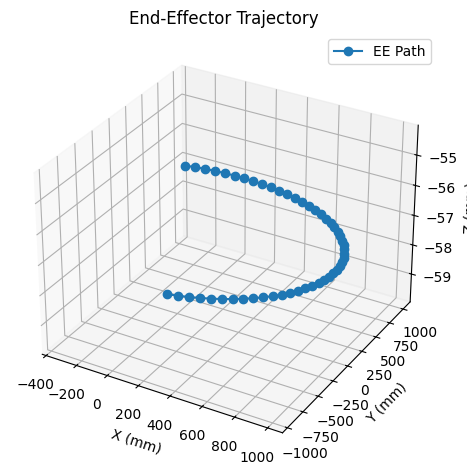

In [33]:
# Simulate sweeping joint 2 from -90 to 90 degrees
trajectory = []
for angle in np.linspace(-90, 90, 50):
    trajectory.append([0, angle, 0, 0, 0, 0])

plot_trajectory(trajectory)
